In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin

In [2]:
# ==========================================
# 1. 自定义转换器：高相关性过滤
# ==========================================
class CorrelationFilter(BaseEstimator, TransformerMixin):
    """
    在 Pipeline 中移除彼此高度相关的特征。
    """
    def __init__(self, threshold=0.95):
        self.threshold = threshold
        self.to_drop = None

    def fit(self, X, y=None):
        # 将输入转为 DataFrame 以便计算相关性
        df = pd.DataFrame(X)
        corr_matrix = df.corr().abs()
        # 选取上三角矩阵
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        # 识别相关性大于阈值的列索引
        self.to_drop = [column for column in upper.columns if any(upper[column] > self.threshold)]
        return self

    def transform(self, X):
        df = pd.DataFrame(X)
        return df.drop(columns=self.to_drop).values

In [4]:
# ==========================================
# 2. 数据加载
# ==========================================
print("正在加载数据...")
df = pd.read_csv('./data/Mordred_descriptors_data_PCE_revised.csv')
# 显示 DataFrame 的前5行
display(df.head())
# 查看 DataFrame 的结构信息，包括列名、非空值数量和数据类型。
df.info()

# First, ensure 'Unnamed: 0' is removed if present.
if 'Unnamed: 0' in df.columns:
    df = df.iloc[:, 1:]
    print("Removed 'Unnamed: 0' column.")

display(df.head())
print("Current df columns:", df.columns.tolist())


正在加载数据...


,Unnamed: 0,PCE,ABC,ABCGG,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,0,52.71,28.378738,22.085071,48.068569,2.508331,4.808260,48.068569,1.264962,4.538485,...,10.395467,90.577762,522.245333,7.253407,5894,57,188,218,13.312500,8.902778
1,1,32.00,55.311853,37.018315,94.364527,2.644020,5.055713,94.364527,1.348065,5.190526,...,11.232934,128.406294,954.400119,7.456251,26176,120,378,457,17.444444,15.611111
2,3,66.00,78.396454,54.602178,132.080526,2.740383,5.227312,132.080526,1.307728,5.550731,...,11.708369,164.053606,1450.541342,7.756906,59853,186,546,674,31.972222,23.000000
3,4,68.00,49.299923,33.339471,83.819771,2.549715,4.950108,83.819771,1.309684,5.078538,...,11.004281,120.512689,899.376918,7.312007,21635,103,330,390,18.611111,14.611111
4,5,42.00,64.544681,45.829246,110.730733,2.544937,5.062404,110.730733,1.318223,5.350337,...,11.340297,141.126097,1138.475015,7.589833,33750,145,436,520,24.888889,19.333333


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Columns: 1121 entries, Unnamed: 0 to mZagreb2
dtypes: float64(1058), int64(63)
memory usage: 1.1 MB
Removed 'Unnamed: 0' column.


,PCE,ABC,ABCGG,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,VE1_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,52.71,28.378738,22.085071,48.068569,2.508331,4.808260,48.068569,1.264962,4.538485,3.757845,...,10.395467,90.577762,522.245333,7.253407,5894,57,188,218,13.312500,8.902778
1,32.00,55.311853,37.018315,94.364527,2.644020,5.055713,94.364527,1.348065,5.190526,4.699575,...,11.232934,128.406294,954.400119,7.456251,26176,120,378,457,17.444444,15.611111
2,66.00,78.396454,54.602178,132.080526,2.740383,5.227312,132.080526,1.307728,5.550731,5.816845,...,11.708369,164.053606,1450.541342,7.756906,59853,186,546,674,31.972222,23.000000
3,68.00,49.299923,33.339471,83.819771,2.549715,4.950108,83.819771,1.309684,5.078538,5.248278,...,11.004281,120.512689,899.376918,7.312007,21635,103,330,390,18.611111,14.611111
4,42.00,64.544681,45.829246,110.730733,2.544937,5.062404,110.730733,1.318223,5.350337,6.953563,...,11.340297,141.126097,1138.475015,7.589833,33750,145,436,520,24.888889,19.333333


Current df columns: ['PCE', 'ABC', 'ABCGG', 'SpAbs_A', 'SpMax_A', 'SpDiam_A', 'SpAD_A', 'SpMAD_A', 'LogEE_A', 'VE1_A', 'VE2_A', 'VE3_A', 'VR1_A', 'VR2_A', 'VR3_A', 'nAromAtom', 'nAromBond', 'nAtom', 'nHeavyAtom', 'nHetero', 'nH', 'nB', 'nC', 'nN', 'nO', 'nS', 'ATS0dv', 'ATS1dv', 'ATS2dv', 'ATS3dv', 'ATS4dv', 'ATS5dv', 'ATS6dv', 'ATS7dv', 'ATS8dv', 'ATS0d', 'ATS1d', 'ATS2d', 'ATS3d', 'ATS4d', 'ATS5d', 'ATS6d', 'ATS7d', 'ATS8d', 'ATS0s', 'ATS1s', 'ATS2s', 'ATS3s', 'ATS4s', 'ATS5s', 'ATS6s', 'ATS7s', 'ATS8s', 'ATS0Z', 'ATS1Z', 'ATS2Z', 'ATS3Z', 'ATS4Z', 'ATS5Z', 'ATS6Z', 'ATS7Z', 'ATS8Z', 'ATS0m', 'ATS1m', 'ATS2m', 'ATS3m', 'ATS4m', 'ATS5m', 'ATS6m', 'ATS7m', 'ATS8m', 'ATS0v', 'ATS1v', 'ATS2v', 'ATS3v', 'ATS4v', 'ATS5v', 'ATS6v', 'ATS7v', 'ATS8v', 'ATS0se', 'ATS1se', 'ATS2se', 'ATS3se', 'ATS4se', 'ATS5se', 'ATS6se', 'ATS7se', 'ATS8se', 'ATS0pe', 'ATS1pe', 'ATS2pe', 'ATS3pe', 'ATS4pe', 'ATS5pe', 'ATS6pe', 'ATS7pe', 'ATS8pe', 'ATS0are', 'ATS1are', 'ATS2are', 'ATS3are', 'ATS4are', 'ATS5are',

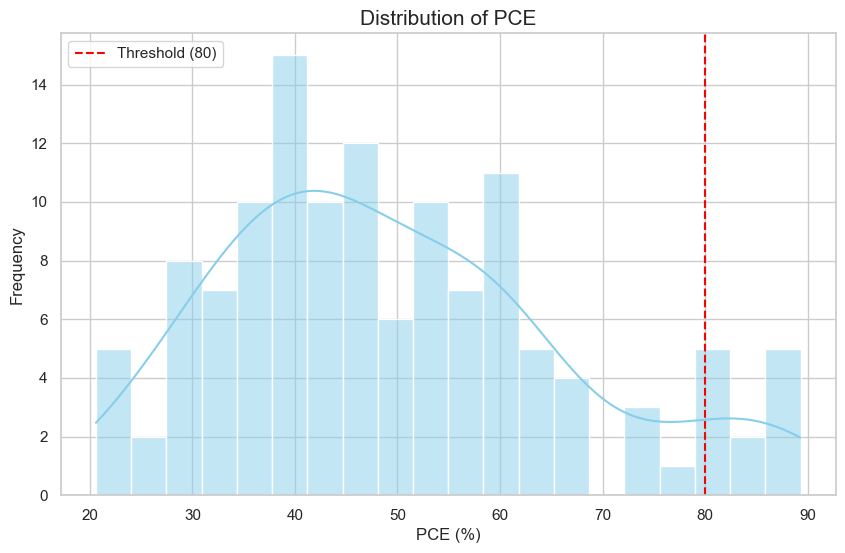

In [5]:
# ==========================================
# 2.1 绘制数据的基础直方图
# 确定 PCE 的集中区间和断层
# ==========================================
# 设置绘图风格
sns.set_theme(style="whitegrid")

def plot_pce_distribution(df, column='PCE'):
    plt.figure(figsize=(10, 6))
    
    # 绘制直方图和 KDE 曲线
    sns.histplot(df[column], kde=True, color="skyblue", bins=20)
    
    # 添加参考线（例如你关注的 80 阈值）
    plt.axvline(x=80, color='red', linestyle='--', label='Threshold (80)')
    
    plt.title(f'Distribution of {column}', fontsize=15)
    plt.xlabel('PCE (%)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.legend()
    plt.show()

plot_pce_distribution(df)

# 1. 基础分布图（Histogram + KDE）：寻找“大部队”与“真空带”

基础分布图由**直方图**（柱状）和**核密度估计曲线**（平滑线KDE）组成。

* **如何确定集中区间（Central Tendency）：**
    * 观察图中**最高的柱子**或**曲线的顶峰**。这个峰值对应的横坐标就是数据的“集中区间”。
    * **化学意义：** 如果峰值在 PCE 15%-20%，说明你的实验体系在这个区间最稳定、最容易重复。


* **如何识别断层（Gaps / Faults）：**
    * 如果在两个柱状簇之间出现了**明显的空隙（频率为 0 的区间）**，这就是断层。
    * **风险预警：** 比如你的数据集中在 20% 以下和 80% 以上，中间 30%-70% 全是空白。这说明你的模型在中间区间处于“盲区”，预测该区间的分子时，模型纯粹是在“瞎猜”，偏差会极大。

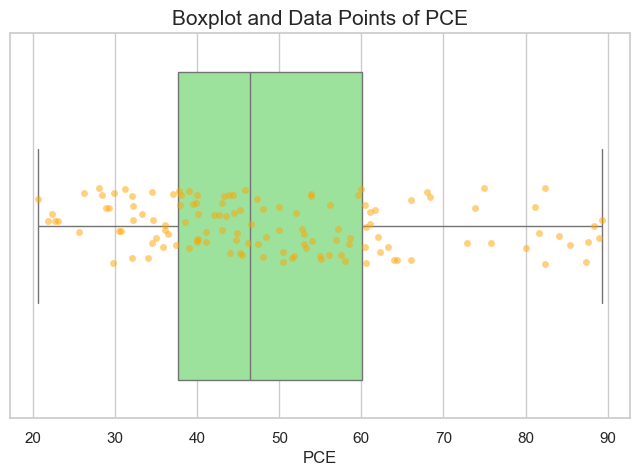

In [6]:
# ==========================================
# 2.2 绘制数据箱线图
# 识别异常值
# ==========================================
def plot_pce_boxplot(df, column='PCE'):
    plt.figure(figsize=(8, 5))
    
    # 绘制箱线图
    sns.boxplot(x=df[column], color="lightgreen")
    
    # 添加散点分布（可以看到具体每个样本的点）
    sns.stripplot(x=df[column], color="orange", alpha=0.5, jitter=True)
    
    plt.title(f'Boxplot and Data Points of {column}', fontsize=15)
    plt.show()

plot_pce_boxplot(df)


# 2. 箱线图（Box Plot）：利用“围栏”圈出离群者

箱线图是基于 **四分位数（Quartiles）** 的统计工具，它定义了一套标准来判定谁是“局外人”。

* **核心逻辑：IQR 准则**
    1. **箱体（Box）：** 下边缘是$Q_1$（前 25% 分位数），上边缘是$Q_3$（前 75% 分位数）。
    2. **四分位距（IQR）：** 箱子的高度$IRQ=Q_3-Q_1$。
    3. **内围栏（Whiskers）：**
        * 上须：$Q_3+1.5IRQ$。
        * 下须：$Q_1-1.5IRQ$。

* **识别异常值（Outliers）：**
    * **判定：** 任何落在上下须范围**之外**的点，都会被标记为单独的小圆点或叉号。
    * **诊断：** 如果你 PCE > 80 的点在箱线图里被标记成了孤立点，说明它们相对于你的主体数据（比如都在 10%-30%）而言是**极端异常**的。模型很难从极少数异常点中学习到普遍规律，这解释了为什么高值区预测不准。

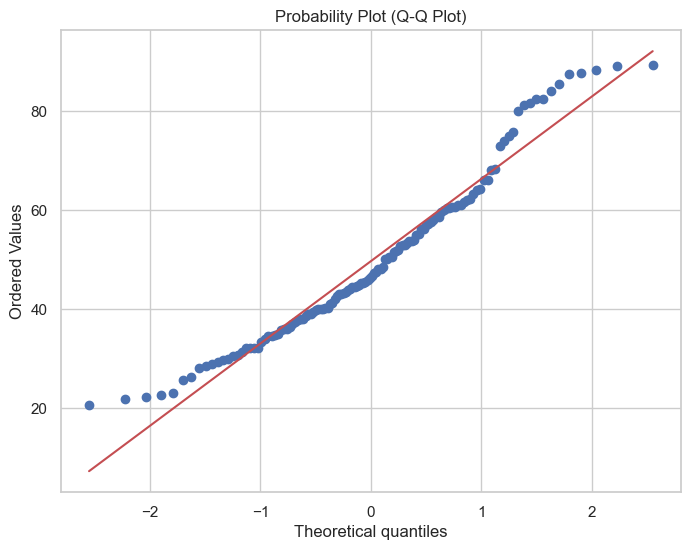

In [7]:
import scipy.stats as stats

# ==========================================
# 2.3 绘制数据的 Q-Q 图
# 检查数据是否符合正态分布
# ==========================================
def plot_qq_plot(df, column='PCE'):
    plt.figure(figsize=(8, 6))
    stats.probplot(df[column], dist="norm", plot=plt)
    plt.title('Probability Plot (Q-Q Plot)')
    plt.show()

plot_qq_plot(df)

# 3. Q-Q 图（Quantile-Quantile Plot）：衡量数据与“理想”的距离

Q-Q 图是将你的数据分位数与**标准正态分布**的分位数进行对比。

* **如何检查正态性：**
    * **理想状态：** 如果你的数据服从正态分布，所有的散点应该**严密地排列在一条 45 度的斜线上**。
    * **识别偏态（Skewness）：**
        * 如果点群在中间贴合，但在两端向上或向下**大幅度弯曲（弧形）**，说明数据存在左偏或右偏。
        * **S 型弯曲：** 说明数据的分布比正态分布更“胖”（厚尾）或更“瘦”（轻尾）。

* **决策参考：**
    * 如果 Q-Q 图显示的散点离直线很远，说明原始 PCE 数据不适合直接进行线性回归或某些统计检验。这时，你需要通过 **Log 变换** 强制将这些散点拉回到斜线上，从而让模型“更好受”。

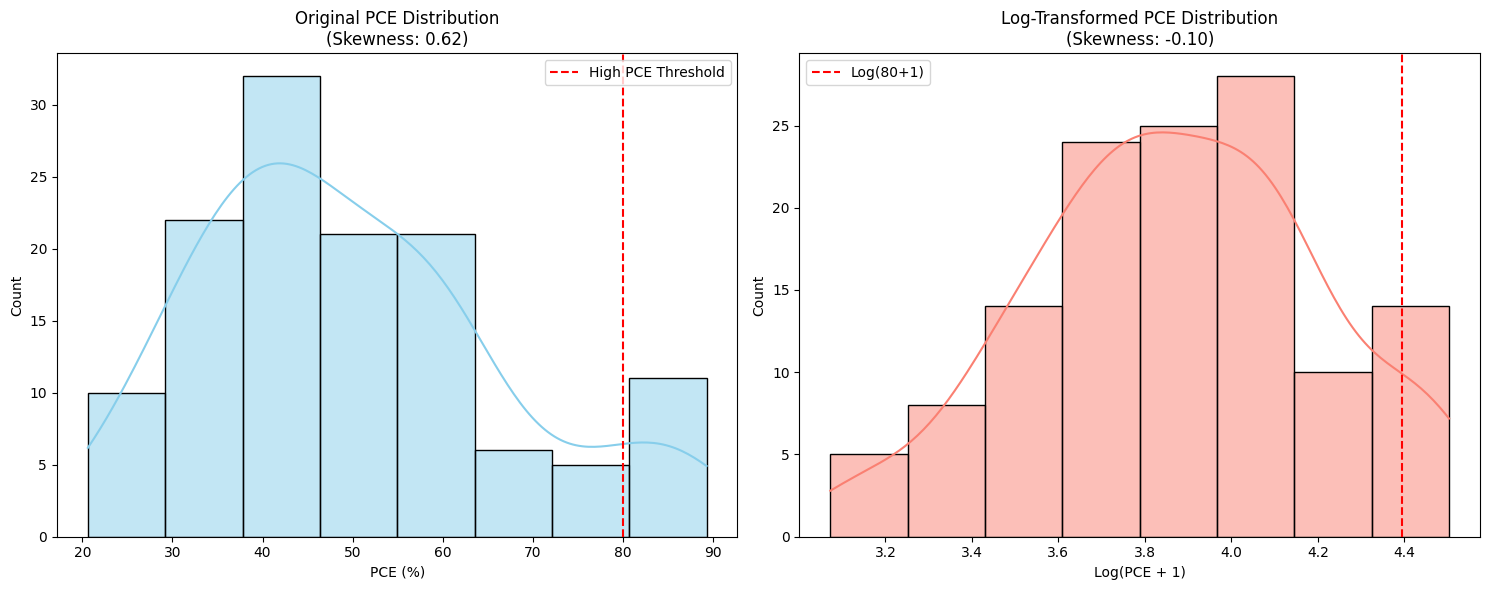

In [5]:
from scipy.stats import skew
# ==========================================
# 2.4 将原始分布与对数变换后的分布进行对比可视化
# ==========================================
def compare_log_transform(df, column='PCE'):
    # 1. 准备数据
    original_data = df[column]
    # 对数变换：log1p 等同于 log(1 + x)
    transformed_data = np.log1p(original_data)

    # 2. 创建画布
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # 3. 绘制原始分布图
    sns.histplot(original_data, kde=True, ax=axes[0], color='skyblue')
    axes[0].set_title(f'Original {column} Distribution\n(Skewness: {skew(original_data.dropna()):.2f})')
    axes[0].set_xlabel('PCE (%)')

    # 4. 绘制对数变换后的分布图
    sns.histplot(transformed_data, kde=True, ax=axes[1], color='salmon')
    axes[1].set_title(f'Log-Transformed {column} Distribution\n(Skewness: {skew(transformed_data.dropna()):.2f})')
    axes[1].set_xlabel('Log(PCE + 1)')

    # 5. 添加视觉辅助线（针对你关注的高值区 80）
    axes[0].axvline(x=80, color='red', linestyle='--', label='High PCE Threshold')
    axes[1].axvline(x=np.log1p(80), color='red', linestyle='--', label='Log(80+1)')
    
    axes[0].legend()
    axes[1].legend()

    plt.tight_layout()
    plt.show()

# --- 使用示例 ---
# compare_log_transform(df_combined)

compare_log_transform(df)

- 偏度 (Skewness) 的改善：
    - 如果原始分布的 Skewness > 1（右偏），说明高 PCE 样本确实很少且分布极不均匀。
    - 对数变换的目标是让 Skewness 更接近 0，使分布更像正态分布。

- 压缩高值区间：
    - 在原始图中，70 到 90 之间的物理距离很大。
    - 在对数图中，高值区间的“距离”被拉近了。这会让回归模型（如随机森林或 SVR）认为这些点之间的差异不再那么“极端”，从而减小模型对极高值的惩罚，提高预测灵敏度。

- 方差齐性：
    - 如果变换后 KDE 曲线变得更对称，模型在不同 PCE 区间的预测误差（残差）会更趋于一致，这能有效解决你提到的“高值区偏差大”的现象。

In [6]:
# ==========================================
# 3. 初始硬清洗
# ==========================================

# 分离特征与目标
y = np.log1p(df['PCE'])
X = df.drop(columns=['PCE'])

# A. 强制数值化：将 Mordred 中的 'Error' 字符串转换为 NaN
X = X.apply(pd.to_numeric, errors='coerce')

# B. 粗筛：移除缺失率超过 50% 的特征（这些特征在当前数据集中不可算）
initial_missing = X.isnull().mean()
X = X.loc[:, initial_missing <= 0.5]

print(f"硬清洗完成。剩余特征数: {X.shape[1]}")

硬清洗完成。剩余特征数: 1119


In [7]:
# ==========================================
# 4. 划分训练集与测试集 (防止数据泄漏)
# ==========================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


最佳参数组合: 
{'correlation_filter__threshold': 0.9, 'regressor__max_depth': None, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 200}
最佳交叉验证 R²: 0.2239

最终数据维度信息:
原始训练集特征维度: (102, 1119)
处理后训练集特征维度 (进入模型的特征): (102, 288)
原始测试集特征维度: (26, 1119)
处理后测试集特征维度 (进入模型的特征): (26, 288)
训练集标签维度: (102,)
测试集标签维度: (26,)
测试集最终 R²: 0.2204
测试集最终 MAE: 0.1961


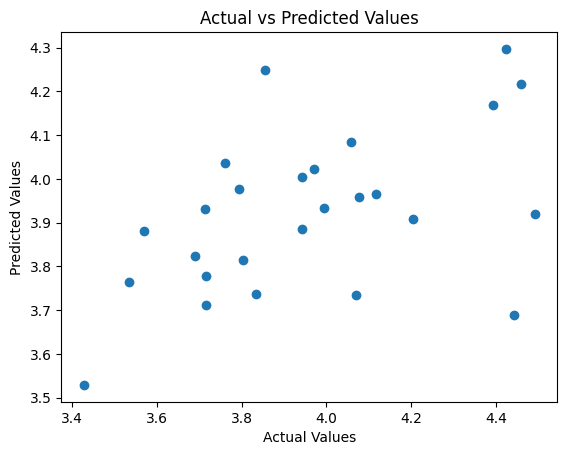

In [ ]:

# ==========================================
# 4. 构建自动化特征工程 Pipeline
# ==========================================
# Pipeline 会记录训练集的统计信息并应用到测试集
model_pipeline = Pipeline([
    # Step 1: 中位数填补 (基于训练集计算中位数)
    ('imputer', SimpleImputer(strategy='median')),
    # Step 2: 低方差过滤 (移除常量和几乎不变的特征)
    ('variance_threshold', VarianceThreshold(threshold=0.01)),
    # Step 3: 高相关性过滤 (移除冗余特征，阈值设为 0.95)
    ('correlation_filter', CorrelationFilter()), # threshold 稍后调优
    # Step 4: 标准化 (均值0，方差1)
    ('scaler', StandardScaler()),
    # Step 5: 回归模型 (以随机森林为例)
    ('regressor', RandomForestRegressor(random_state=42)) # 超参数稍后调优
])
# --- 1. 定义参数网格 ---
# 格式：步骤名__参数名
param_grid = {
    'correlation_filter__threshold': [0.90, 0.95, 0.98],# 调优特征冗余度
    'regressor__n_estimators': [100, 200],              # 森林中树的数量
    'regressor__max_depth': [None, 10, 20],             # 树的最大深度
    'regressor__min_samples_split': [2, 5]              # 分裂节点所需的最小样本数
}
# --- 2. 使用 GridSearchCV 进行超参数调优 ---
# n_jobs=-1 使用所有 CPU 核心加速计算
grid_search = GridSearchCV(model_pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

# --- 3. 输出最佳参数和模型性能 ---
print("\n" + "="*30)
print(f"最佳参数组合: \n{grid_search.best_params_}")
print(f"最佳交叉验证 R²: {grid_search.best_score_:.4f}")
print("="*30)

# --- 4. 使用最佳模型进行预测 ---
best_model = grid_search.best_estimator_

# --- 4.1 (新增) 打印最终特征和标签维度 ---
# 使用 best_model[:-1] 获取除最后一步(回归器)之外的所有预处理步骤
# 这样可以对数据进行变换，查看经过特征选择和处理后的实际维度
X_train_final = best_model[:-1].transform(X_train)
X_test_final = best_model[:-1].transform(X_test)

print("\n" + "="*30)
print("最终数据维度信息:")
print(f"原始训练集特征维度: {X_train.shape}")
print(f"处理后训练集特征维度 (进入模型的特征): {X_train_final.shape}")
print(f"原始测试集特征维度: {X_test.shape}")
print(f"处理后测试集特征维度 (进入模型的特征): {X_test_final.shape}")
print(f"训练集标签维度: {y_train.shape}")
print(f"测试集标签维度: {y_test.shape}")
print("="*30)

y_pred = best_model.predict(X_test)

# --- 5. 评估模型性能 ---
print(f"测试集最终 R²: {r2_score(y_test, y_pred):.4f}")
print(f"测试集最终 MAE: {mean_absolute_error(y_test, y_pred):.4f}")
print("="*30)

# --- 6. 可视化预测结果 ---
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

正在分析 GridSearchCV 的最佳模型...
方差过滤后剩余特征数: 905
相关性过滤后剩余特征数: 288

=== 特征重要性 Top 20 ===
        Feature  Importance
0        ATSC3s    0.046744
1        GATS1s    0.042304
2          SdsN    0.036814
3       AATS7se    0.028790
4           IC1    0.025883
5   VSA_EState3    0.025190
6       AATSC1Z    0.018984
7         SaasC    0.017631
8        GATS3s    0.017619
9        ATSC6i    0.017416
10       GATS5s    0.015333
11  TopoPSA(NO)    0.014156
12      AATSC3v    0.013648
13          IC3    0.013255
14       GATS3i    0.013061
15       ATSC6v    0.011869
16     AATSC1dv    0.010770
17      AATSC4v    0.010461
18       ATSC4s    0.009760
19  VSA_EState4    0.009551


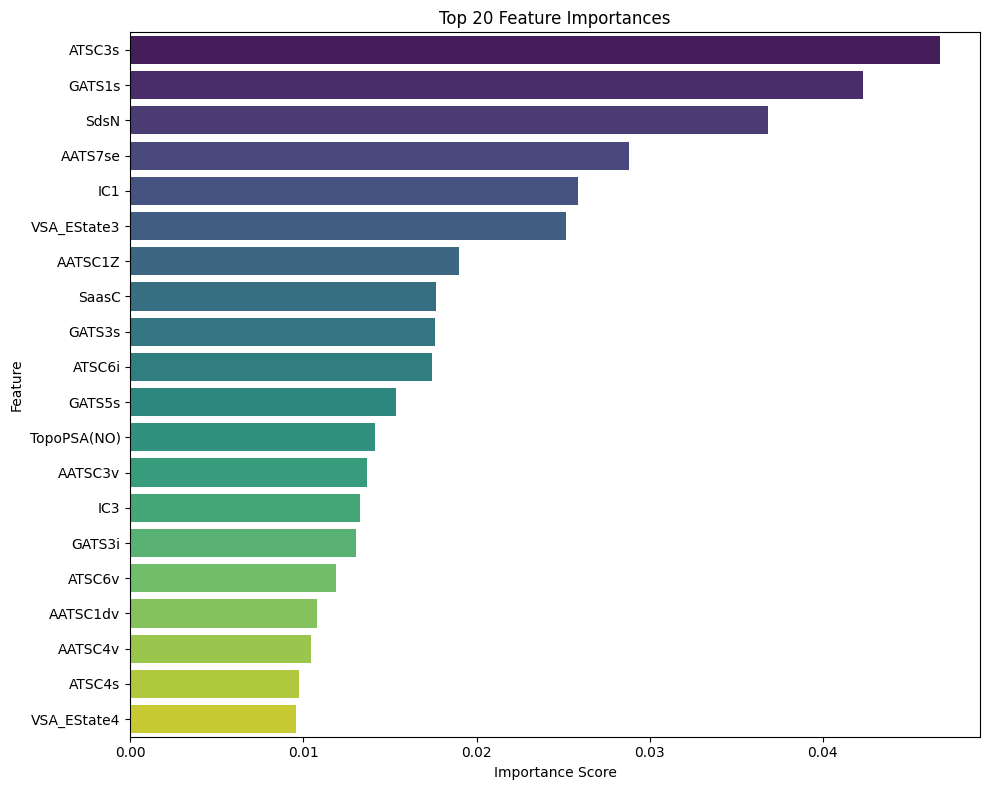


已提取前 50 个重要特征，存储在变量 `top_50_features` 中。

特征工程已完成，模型已就绪。


In [ ]:
# ==========================================
# 5. 查看特征重要性与提取
# ==========================================

# 1. 确定最佳模型
# 优先使用 GridSearchCV 的最佳模型，如果未定义则使用 model_pipeline
if 'grid_search' in locals() and hasattr(grid_search, 'best_estimator_'):
    best_pipeline = grid_search.best_estimator_
    print("正在分析 GridSearchCV 的最佳模型...")
else:
    best_pipeline = model_pipeline
    print("正在分析 model_pipeline...")

# 2. 还原特征名称 (Feature Name Tracking)
# 我们需要追踪特征经过 Pipeline 各个步骤后的变化
feature_names = list(X.columns)

# 获取 Pipeline 中的关键步骤对象
step_variance = best_pipeline.named_steps['variance_threshold']
step_corr = best_pipeline.named_steps['correlation_filter']
step_model = best_pipeline.named_steps['regressor']

# A. 模拟 VarianceThreshold 的筛选
# get_support() 返回布尔列表，表示哪些特征被保留
vt_mask = step_variance.get_support()
feature_names = [name for name, keep in zip(feature_names, vt_mask) if keep]
print(f"方差过滤后剩余特征数: {len(feature_names)}")

# B. 模拟 CorrelationFilter 的筛选
# 注意：由于前一步输出是 numpy array，CorrelationFilter 处理的是无名数组
# 因此它的 to_drop 属性存储的是整数索引（即在方差过滤后的特征列表中的下标）
if hasattr(step_corr, 'to_drop') and step_corr.to_drop is not None:
    drop_indices = set(step_corr.to_drop)
    # 保留那些索引不在删除列表中的特征
    feature_names = [name for i, name in enumerate(feature_names) if i not in drop_indices]
    print(f"相关性过滤后剩余特征数: {len(feature_names)}")
else:
    print("警告: CorrelationFilter 未记录删除的列，可能未被拟合。")

# 3. 提取特征重要性并可视化
if hasattr(step_model, 'feature_importances_'):
    importances = step_model.feature_importances_
    
    # 检查维度是否匹配（防止意外错误）
    if len(importances) != len(feature_names):
        print(f"错误: 特征名数量({len(feature_names)}) 与 重要性得分数量({len(importances)}) 不匹配！")
    else:
        # 构建 DataFrame
        feature_imp_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        })
        
        # 按重要性降序排序
        feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)
        
        # 打印 Top 20
        print("\n=== 特征重要性 Top 20 ===")
        print(feature_imp_df.head(20))
        
        # 可视化
        plt.figure(figsize=(10, 8))
        sns.barplot(
            x='Importance', 
            y='Feature', 
            hue='Feature',
            data=feature_imp_df.head(20), 
            palette='viridis',
            legend=False
        )
        plt.title('Top 20 Feature Importances')
        plt.xlabel('Importance Score')
        plt.tight_layout()
        plt.show()
        
        # 4. 提取重要特征列表供后续使用
        # 例如：提取前 50 个最重要的特征
        top_50_features = feature_imp_df['Feature'].head(50).tolist()
        print(f"\n已提取前 50 个重要特征，存储在变量 `top_50_features` 中。")
else:
    print(f"当前模型 {type(step_model).__name__} 不支持 feature_importances_ 属性。")

print("\n特征工程已完成，模型已就绪。")

In [ ]:
def save_results(results_dir, best_model, best_params, metrics, top_features):
    """
    模块 5: 结果保存 (日志与 JSON)
    """
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)

    timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    # 1. 保存最佳参数日志 (追加模式)
    log_file = os.path.join(results_dir, 'best_params_rf.log')
    with open(log_file, 'a', encoding='utf-8') as f:
        f.write(f"[{timestamp}] Best Params: {best_params}, Best CV R2: {metrics['cv_r2']:.4f}, Test R2: {metrics['r2']:.4f}\n")
    print(f"最佳参数已追加保存至: {log_file}")

    # 2. 保存重要特征列表 (追加模式)
    feature_save_path = os.path.join(results_dir, 'top_50_features_rf.json')
    data_list = []
    if os.path.exists(feature_save_path):
        try:
            with open(feature_save_path, 'r', encoding='utf-8') as f:
                data_list = json.load(f)
                if not isinstance(data_list, list):
                    data_list = [data_list]
        except Exception:
            data_list = []

    record = {
        "timestamp": timestamp,
        "cv_r2": metrics['cv_r2'],
        "features": top_features
    }
    data_list.append(record)

    with open(feature_save_path, 'w', encoding='utf-8') as f:
        json.dump(data_list, f, ensure_ascii=False, indent=4)
    print(f"重要特征列表已追加保存至: {feature_save_path}")

    # 3. 保存最佳模型文件
    model_save_path = os.path.join(results_dir, 'model_rf.pkl')
    joblib.dump(best_model, model_save_path)
    print(f"最佳模型已保存至: {model_save_path}")